From code on a private computer, available as [final_template_plots.c on our OSF project](https://osf.io/a54h9/).

*Translation from C to Python not yet complete.*

# Setup

In [1]:
import matplotlib.pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')
import uproot
import os
import sys
sys.path.append('../python/')
from analysisUtils import * #.L /home/mastx027/cdms/analysisUtils.c

ROOT.gStyle.SetOptStat(0);
ROOT.gStyle.SetHistLineWidth(2)

/home/gerudo7/.local/lib/python3.8/site-packages/uproot/reading.py:186: FutureWarning: XRootD 4.12.3 is not fully supported; either upgrade to 5.2.0+ or set

    open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

  warnings.warn(message, FutureWarning)


Welcome to JupyROOT 6.22/00


# Plot just PT template

4096
4096


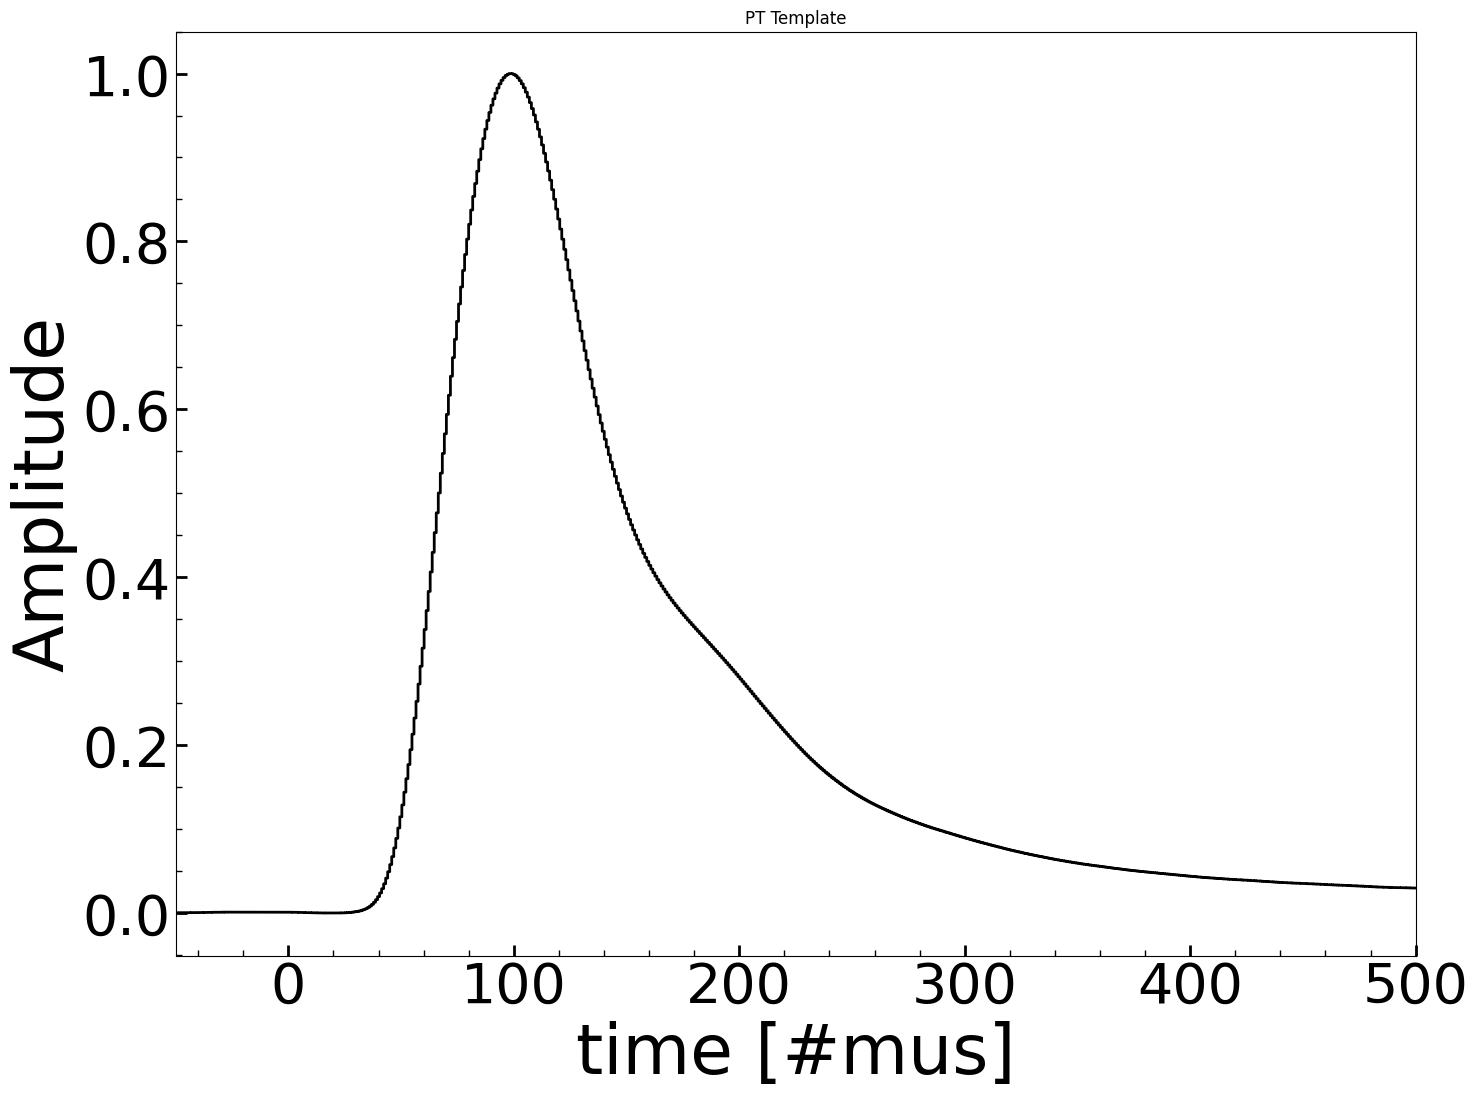

In [2]:
fo = uproot.open('templates/Z1_Templates_UMN_R68_n125_v9.root') #TFile *fo = new TFile("templates/Z1_Templates_UMN_R68_n125_v9.root","READ");
PT = fo['zip1/PT;1']
PTvals = PT.to_numpy()[0]
PTbins = PT.to_numpy()[1]

ww = 400 #int ww=400

hPT = rescaleX(PTbins,-400,0.8)
#hPT = np.histogram(PTvals,len(PTbins))
print(len(hPT))
print(len(PTvals))

#fig = plt.figure(figsize=(ww,ww*0.75)) #TCanvas *c1 = new TCanvas("c1","c1",ww,ww*0.75)
plt.step(hPT,PTvals, color='black', linewidth=2) #hPT.SetLineColor(kBlack) #hPT.SetLineWidth(2)
plt.title("PT Template")  #hPT.SetTitle("PT Template;
plt.xlabel("time [#mus]") #time [#mus];
plt.ylabel("Amplitude")   #Amplitude")
plt.xlim([-50,500]) #hPT.SetAxisRange(-50,500)

plt.show() #hPT.Draw()

# Plot a good fit to a pulse

In [3]:
######################################
#Don't run this cell more than once! #
#You'll mess up all the array shapes.#
#If you need to rerun it, restart the#
#kernel.                             #
######################################

directory = 'data/byseries/' #TString directory='/data/chocula/k100/reprocessing/run068_1/midasrq/byseries/'
series = ['07180924_1710']  #TString series[]={"07180924_1710"};//07180925_1329"};
nSer = 1 #int nSer=1;        
    
#z = uproot.iterate([directory+series[0]+'/*.root:rqDir/zip1'],allow_missing=True) #ROOT.TChain("rqDir/zip1")
#e = uproot.iterate([directory+series[0]+"/*.root:rqDir/eventTree"],allow_missing=True)
#p = uproot.open(directory+series[0]+"/"+series[0]+"_traces.root:RawTraces")#:RawTraces

z = {}
e = {}
p = {}

#open files so that we get a sequential vector from file 01 to file 10 where all vectors are in order
#e.g. [[vec1], [vec2], [vec3],...]


for file in sorted(os.listdir(directory+series[0])):                                                   #For every file in the series subdirectory, in alphabetical order,
    if file.endswith('.root') and not file.endswith('_traces.root'):                                   #If the file is a root file and not the traces file,
        openfile = uproot.open(directory+series[0]+'/'+file+":rqDir")                                  #Open the file.
        for key in openfile["zip1"].keys():                                                            #For each key in zip1 in the file,
            if key in z:                                                                               #If the key is already in the z variable,
                z[key].append(openfile["zip1"][key])                                                   #Append it to the exisisting key
            else:                                                                                      #Otherwise,
                z.update({key : [openfile["zip1"][key]]})                                              #Create said key.
        for key in openfile["eventTree"].keys():                                                       #Now for each key in eventtree,
            if key in e:                                                                               #Do the same but with the e variable.
                e[key].append(openfile["eventTree"][key])
            else:
                e.update({key : [openfile["eventTree"][key]]})
    elif file.endswith('_traces.root'):                                                                #Otherwise, if it's the traces file,
        openfile = uproot.open(directory+series[0]+'/'+file+":RawTraces")   
        for key in openfile.keys():                                                                    #Do all that for all keys and into the p variable.
            if key in p:
                p[key].append(openfile[key])
            else:
                p.update({key : [openfile[key]]})

i = 0
#z.Add(ROOT.Form("%s%s/umn*.root",directory.Data(),series[i].Data()))
while i<nSer: #for(int i=0;i<nSer;i++){
    for file in os.listdir(directory+series[i]):
        if file.startswith('umn') and file.endswith('.root'):
            openfile = uproot.open(directory+series[i]+'/'+file)
            for key in openfile.keys():
                if key in z:
                    z[key].append(openfile[key])
                else:
                    z.update({key: [openfile[key]]})
    #e.Add(ROOT.Form("%s%s/umn*.root",directory.Data(),series[i].Data()))
    for file in os.listdir(directory+series[i]):
        if file.startswith('umn') and file.endswith('.root'):
            openfile = uproot.open(directory+series[i]+'/'+file)
            for key in openfile.keys():
                if key in e:
                    e[key].append(openfile[key])
                else:
                    e.update({key: [openfile[key]]})
    #p.Add(ROOT.Form("/home/mastx027/cdms/analysis/run068/trigger/%s_traces.root",series[i].Data()))
    with uproot.open(directory+series[i]+'/'+series[i]+'_traces.root') as openfile:
        for key in openfile.keys():
            if key in p:
                p[key].append(openfile[key])
            else: 
                p.update({key: [openfile[key]]})
    i += 1

for key in e:  #z.AddFriend(e)
    if key in z:
        z[key] += e[key]
    else:
        z.update({key: e[key]})
for key in p:  #z.AddFriend(p)
    if key in z:
        z[key] += p[key]
    else:
        z.update({key: p[key]})

## Cuts

In [4]:
#How do I make these actual cuts? Seems to use uproot .arrays "aliases" function
#But how do I apply these in a more general sense?

crand = z["EventCategory"] #TCut crand = "EventCategory";
#TCut cchit = "PTOFchisq<(PTOFamps>6e-6)*((PTOFamps-6e-6)/3e-8)**2+PTOFamps/2e-9+5e3";
cchit = [[
        z["PTOFchisq"][i].array()[j] < (x>6e-6)*((x-6e-6)/3e-8)**2+x/2e-9+5e3 
        for j,x in enumerate(arr.array())]for i,arr in enumerate(z["PTOFamps"])]

#zs needs to be in uproot's "default" format, but I can't figure out how to get it there
#have tried appending, have tried using uproot.lazy and uproot.concatenate
#Problem could be avoided if I found a better way to replace AddFriend


################Never called#################

#cBShi = z["PFbs"]-z["PFbsmean"]>1500 #TCut cBShi="PFbs-PFbsmean>1500";
#cFstd = z["PFstd"]<2.5e-7 #TCut cFstd="PFstd<2.5e-7";
#cofdel = z["PTOFdelay"]<23e-6 and z["PTOFdelay"]>-74e-6 #TCut cofdel="(PTOFdelay<23e-6 && PTOFdelay>-74e-6)";
#cofwktiming = z["PTOFdelay"]*1e6<z["PTWKr50"]*1e6-390 and z["PTOFdelay"]*1e6>z["PTWKr50"]*1e6-470 #TCut cofwktiming = "(PTOFdelay*1e6<PTWKr50*1e6-390 && PTOFdelay*1e6>PTWKr50*1e6-470)";
#cglitch = 1e6*(z["PTWKf20"]-z["PTWKr100"])<12 #TCut cglitch = "1e6*(PTWKf20-PTWKr100)<12";
#cspikey = 1e6*(z["PTWKf20"]-z["PTWKr100"])<35 #TCut cspikey = "1e6*(PTWKf20-PTWKr100)<35";

#z.update({"PTINTall_PTdbscorr":z["PTINTall"]-(z["PTdbs"]<0)*0.5*(z["PTdbs"]*4096./z["PAnorm"])})#z->SetAlias("PTINTall_PTdbscorr","PTINTall-(PTdbs<0)*0.5*(PTdbs*4096./PAnorm)")
#z.update({"PTINTall_PTdbscorr_bscorr":z["PTINTall_PTdbscorr"]*(1.+0.20*(z["PFbs"]-z["PFbsmean"])/2e3)})#z->SetAlias("PTINTall_PTdbscorr_bscorr","PTINTall_PTdbscorr*(1.+0.20*(PFbs-PFbsmean)/2e3)")

#cofintHi_PuBe = z["PTINTall_PTdbscorr_bscorr"] > (z["PTOFamps"]>9.59954e-06)*1.22032e+07*(z["PTOFamps"]-9.59954e-06)**2+171.253*z["PTOFamps"]+1e-4 #TCut TCut cofintHi_PuBe="PTINTall_PTdbscorr_bscorr> (PTOFamps>9.59954e-06)*1.22032e+07*(PTOFamps-9.59954e-06)**2+171.253*PTOFamps+1e-4" #TCut cofintHi_PuBe="PTINTall_PTdbscorr_bscorr> (PTOFamps>9.59954e-06)*1.22032e+07*(PTOFamps-9.59954e-06)**2+171.253*PTOFamps+1e-4" #TCut TCut cofintHi_PuBe="PTINTall_PTdbscorr_bscorr> (PTOFamps>9.59954e-06)*1.22032e+07*(PTOFamps-9.59954e-06)**2+171.253*PTOFamps+1e-4";

#cnopulsepus = cofdel and not cofintHi_PuBe and cofwktiming #TCut cnopulsepus=cofdel&&!cofintHi_PuBe&&cofwktiming

## Calibration

In [5]:
line14 = 13.95 #float line14 = 13.95,
line18 = 17.74 #line18 = 17.74;//[keV]
peak14 = 1.11291e-05 #float peak14 = 1.11291e-05,
peak18 = 1.30754e-05 #peak18 = 1.30754e-05;//OFamps

pquad = (peak18*line14-peak14*line18)/(peak18*peak14**2-peak14*peak18**2)      #float pquad = (peak18*line14-peak14*line18)/(peak18*peak14**2-peak14*peak18**2);
plin = (peak14**2*line18-peak18**2*line14)/(peak18*peak14**2-peak14*peak18**2) #float plin = (peak14**2*line18-peak18**2*line14)/(peak18*peak14**2-peak14*peak18**2);
z.update({"PTOFkeV":
            [[
            plin*x+pquad*x**2
            for x in arr.array()] for arr in z["PTOFamps"]]
         })#z->SetAlias("PTOFkeV",Form("%e*PTOFamps+%e*PTOFamps**2",plin,pquad));

## Load Pulses

In [6]:
names = ["PA","PB","PC","PD","PE","PF","PT"] #TString names[]={"PA","PB","PC","PD","PE","PF","PT"};

bs = [0,0,0,0,0,0,0] #Double_t bs[7]={0,0,0,0,0,0,0};
rawPulse = [0,0,0,0,0,0,0] #TH1D *rawPulse[7]={0,0,0,0,0,0,0};
temp = [0,0,0,0,0,0,0] #TH1D *temp[7]={0,0,0,0,0,0,0};

i = 0
while i<6:#for(Int_t i=0;i<6;i++){
    rawPulse[i] = z[names[i]][0]
    bs[i] = z[names[i]][0] #each of these is an array with 1 entry; retrieve the entry, not the array
    i += 1

In [7]:
PTrc=[1.128, 1.323, 0.732, 1.24, 0.929, 0.647] #double PTrc[6]={1.128, 1.323, 0.732, 1.24, 0.929, 0.647}

#z->Draw(">>elist2",!crand&&cchit&&"PTOFkeV>100e-3&&PTOFkeV<150e-3") #Draw z, save to elist2, the rest is a cut.
"""#Commenting out for now because I don't need this plot and it's confusing me.
z.Draw(">>elist2",crand == False and cchit and 
       [[x > 100e-3 and x < 150e-3
       for x in arr.array()] for arr in z["PTOFkeV"]]
      )
#"""
iEntry=36046 #0.46 keV #THIS! Is where we determine! Which event is used.
#z.GetEntry(iEntry)

#flat bs subtract, zero first 8 bins, and scale by PT weighting
iChan = 0
while iChan<6:#for(int iChan=0;iChan<6;iChan++){
    rawPulse[iChan].show()
    print(rawPulse[iChan].name)
    print(rawPulse[iChan].array(library='np'))
    BSsubtract(rawPulse[iChan],bs[iChan]) #From analysisUtils.py - subtract bs[iChan] from all bins in rawPulse[iChan]
    zeroFirst8(rawPulse[iChan])           #From analysisUtils.py - set first 8 bins to 0.
    rawPulse[iChan].Scale(PTrc[iChan])
    iChan += 1
#build PT
print(rawPulse[0])
rawPulse[6]=rawPulse[0]#rawPulse[6]=(TH1D*)rawPulse[0]->Clone();
rawPulse[6].SetTitle("PT") #rawPulse[6]->SetTitle("PT");
rawPulse[6].SetName("PT")  #rawPulse[6]->SetName("PT");
iChan=1
while iChan<6:#for(int iChan=1;iChan<6;iChan++){
    rawPulse[6].Add(rawPulse[iChan])#rawPulse[6]->Add(rawPulse[iChan]);}
    iChan += 1

hPTraw = rescaleX(rawPulse[6][0],-400,0.8) #TH1D *hPTraw = rescaleX(rawPulse[6],-400,0.8)

ADC = True #bool ADC=true //Plot in ADC units as opposed to "amps"

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
PA                   | TH1D                     | AsObjects(Model_TH1D)         
PA


NotImplementedError: memberwise serialization of Model_TAxis_v9
in file data/byseries/07180924_1710/07180924_1710_traces.root

In [ ]:
#//Scale by (incorrect) normalization to amps
#norm = z->GetLeaf("PAnorm")->GetValue()

if !ADC: #if(!ADC){
    #hPTraw->Scale(1e6/norm);}

#TH1D *hPT = rescaleX(PT,-400,0.8)
#hPT->SetLineColor(kBlack)
#hPT->SetLineWidth(2)
#OFamps=z->GetLeaf("PTOFamps")->GetValue()

if !ADC: #if(!ADC){
    #hPT->Scale(OFamps*1e6);}else{hPT->Scale(OFamps*norm);}

#shiftTrace(hPT,int((z->GetLeaf("PTOFdelay")->GetValue())/0.8e-6))

#//Get OFkeV
#z->Draw("PTOFkeV",Form("Entry$==%i",iEntry))
#double OFenergy=z->GetV1()[0]

In [ ]:
#//Pretty plot

fig = figure()

if !ADC:#if(!ADC){
    fig.set_xlabel("time [#mus]") #hPTraw->SetTitle(";time [#mus];
    fig.set_ylabel("Amplitude [#muA]") #Amplitude [#muA]");}
else:#else{
    fig.set_xlabel("time [#mus]")#hPTraw->SetTitle(";time [#mus];
    fig.set_ylabel("Amplitude [ADC]")#Amplitude [ADC]");}
title.fontsize=(5) #hPTraw->GetXaxis()->SetTitleSize(0.05)

fig.set_xlim([-200,800]) #hPTraw->SetAxisRange(-200,800); hPT->SetAxisRange(-200,800)

#//Just draw the axis first
#hPTraw->SetLineWidth(1)
plot(,color='black',linewidth='2') #hPTraw->SetLineColor(kBlack); hPTraw->SetLineWidth(2); hPTraw->Draw()

#//Include OF delay window on bottom layer
#TLine *l1 = new TLine()

plot(color='blue',linewidth=3) #l1->SetLineColor(kBlue); l1->SetLineWidth(3)
#l1->DrawLine(-75,c1->GetUymin(),-75,c1->GetUymax())
#l1->DrawLine(25,c1->GetUymin(),25,c1->GetUymax())

#TBox *b1 = new TBox(-75,c1->GetUymin(),25,c1->GetUymax())
fill_between(color='blue') #b1->SetFillColor(kBlue)

#//Then draw pulses
plot(color='red',linewidth=2) #hPTraw->SetLineWidth(2)
#hPTraw->Draw("same")
plot(color='red',linewidth=3) #hPT->SetLineColor(kRed); hPT->SetLineWidth(3)
#hPT->Draw("same")

legend(labels=["Raw PT", "OF fit", "OFdelay window"])#TLegend *leg = new TLegend(0.6,0.6,0.9,0.9); leg->AddEntry(hPTraw,"Raw PT","L"); leg->AddEntry(hPT,"OF fit","L"); leg->AddEntry(l1,"OFdelay window","L"); 

savefig('figures/r68_n125_PT_template_egfit_noNRG.pdf')#c1->SaveAs("/home/mastx027/cdms/analysis/run068/images/paper/r68_n125_PT_template_egfit_noNRG.pdf")
show()#leg->Draw("same")